In [1]:
import sys
sys.path.append("..")

In [206]:
import os
import cv2
import torch
import random
import numpy as np
from PIL import Image
from src.io import read_rgb
from src.io import load_config
import matplotlib.pyplot as plt
import torch.nn.functional as F
from src.transform import Transform
from src.model import create_model, load_state_dict
from src.dataset import RoadDataset, RoadInferenceDataset

In [207]:
def visualize(
    image: np.array, 
    gt_mask: np.array, 
    mask: np.array, 
    category: str, 
):
    """plots images in one row
    """
    
    plt.figure(figsize=(32, 9))
    plt.subplot(1, 3, 1)
    plt.title(f"Grount Truth Image + Mask")
    color = np.array([0, 0, 255], dtype=np.uint8)
    if gt_mask is not None:
        masked_img = np.where(gt_mask[..., None], color, image)
        gt_image = cv2.addWeighted(image, 0.5, masked_img, 0.5, 0)
    else:
        gt_image=image
    
    #gt_image = cv2.rotate(gt_image, cv2.ROTATE_90_CLOCKWISE)
    plt.imshow(gt_image)
    
    plt.subplot(1, 3, 2)
    plt.title(f"Pred Mask for {category}")
    # mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    # masked_img = np.where(mask[...,None], color, img)
    color = np.array([0, 0, 255], dtype=np.uint8)
    masked_img = np.where(mask[..., None], color, image)
    pred_image = cv2.addWeighted(image, 0.5, masked_img, 0.5, 0)
    #pred_image = cv2.rotate(pred_image, cv2.ROTATE_90_CLOCKWISE)
    plt.imshow(pred_image)
    plt.show()

### **Checkpoints and config from experiments**

In [208]:
ckpt_path = None # insert your path here
config_path = None # insert your path here

In [209]:
config = load_config(config_path)

In [210]:
model = create_model(**config["model"])

##### Segmentation Model #####
> Architecture: UNET
> Backbone: resnet34
> Weights from: imagenet
- Num classes: 1
###############################


In [211]:
state_dict = load_state_dict(ckpt_path=ckpt_path)
model.load_state_dict(state_dict)
model.eval();

In [267]:
pothole_threshold=.1

### **Dataset**

In [268]:
data_dir = None # insert your path here

In [269]:
dataset = RoadDataset(
    data_dir=data_dir,
    train=False,
    transform=Transform(
        train=False,
        **config["transform"]
    )
)

## **Inference + plot on random images**

Image index 146 - Image: /Users/riccardomusmeci/Developer/data/github/smart-arrotino/pothole/dataset/split/val/images/5322ae2a-25.jpg


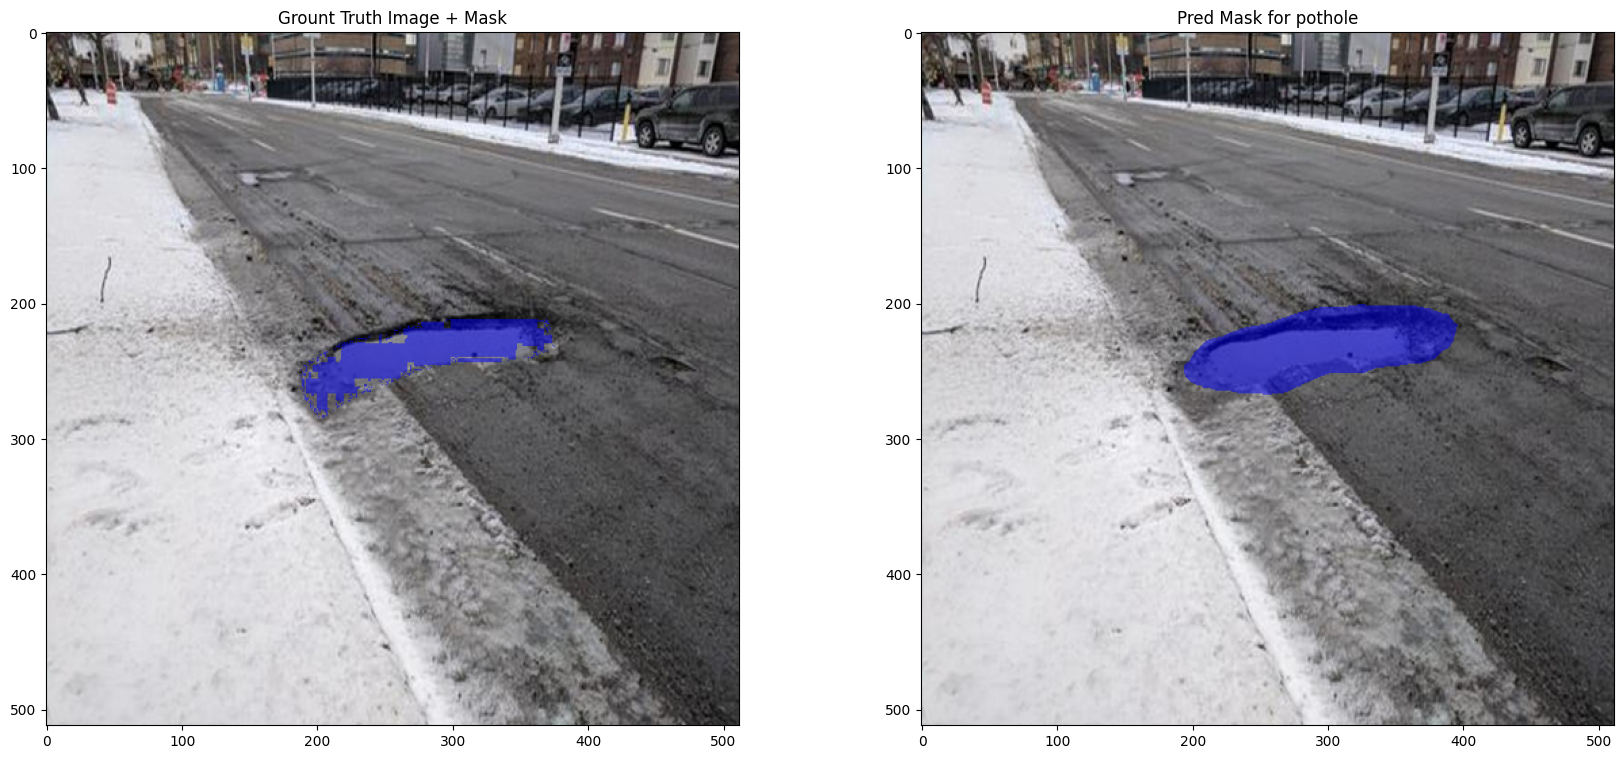

In [297]:
# Random selection
index = random.randint(0, len(dataset))
img_path = os.path.join(data_dir, "val", "images", dataset.images[index])
print(f"Image index {index} - Image: {img_path}")

# Model Inference
with torch.no_grad():
    x, mask = dataset[index]
    x = x.unsqueeze(0)
    logits = model(x)
    preds = torch.sigmoid(logits)

# Open image
img = Image.open(img_path).convert("RGB")
img = img.resize(config["transform"]["input_size"])

# Prediction mask filtered
pred_mask = preds.squeeze().numpy()
pred_mask[pred_mask>=pothole_threshold] = 255
pred_mask[pred_mask<pothole_threshold] = 0

# Plotting
visualize(
    image=np.array(img),
    gt_mask=mask.squeeze().numpy(),
    mask=pred_mask,
    category="pothole"
)